### Описание эксперимента
Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

#### Описание колонок:
value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

### Задача.
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. 

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu, mode
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('hw_bootstrap.csv', sep=';', index_col=0)

In [3]:
df.head()

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control


In [4]:
df.shape

(1000, 2)

In [5]:
df.dtypes
# value - object и разделены запятой, мы не сможем их посчитать без преобразования

value                object
experimentVariant    object
dtype: object

In [6]:
df['value']=df.value.apply(lambda s: float(s.replace(',', '.'))) # приведение данных в нужный формат

In [7]:
df.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [8]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [9]:
df.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [10]:
# отберем данные по контрольной группе
df_control = df.query("experimentVariant == 'Control'")
df_control.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [11]:
# отберем данные по тестовой группе
df_test = df.query("experimentVariant == 'Treatment'")
df_test.head()

,value,experimentVariant
501,10.380495,Treatment
502,9.546867,Treatment
503,11.088215,Treatment
504,10.147274,Treatment
505,9.789808,Treatment


In [12]:
# Посмотрим кол-во наблюдений в контрольной и тестовой группе.
# Кол-во наблюдений в обоих группах одинаковое
num1 = df_control.value.count()
num2 = df_test.value.count()
num1, num2

(500, 500)

Посмотрим на распределение в контрольной группе.
Контрольная группа имеет нормальное распределение.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


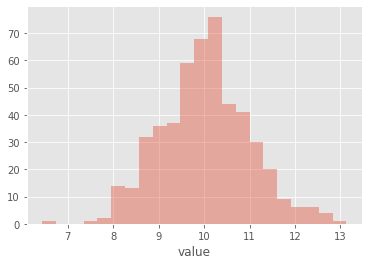

In [13]:
sns.distplot(df_control.value, kde=False)

Посмотрим на распределение значений тестовой группы.
Распределение в тестовой группе не нормальное с выбросом.

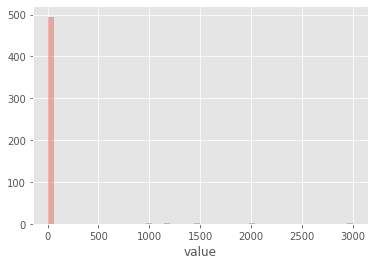

In [14]:
sns.distplot(df_test.value, kde=False)

#### Так как в тестовой группе распределение не нормальное мы не можем использовать критерий Стьюдента (t-тест).

In [15]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [16]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [17]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

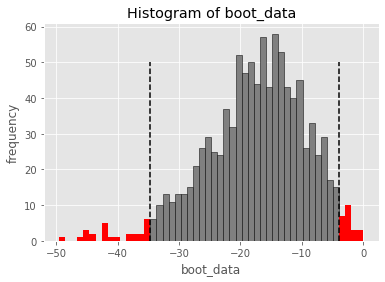

In [18]:
booted_data = get_bootstrap(df_control.value, df_test.value) 

в результате хранится разница двух распределений, ДИ и pvalue

на графике видно, что доверительный интервал не пересёк ноль, таким образом мы можем отклонить нулевую гипотезу

In [19]:
booted_data["p_value"] # альфа


0.030819456514591972

In [20]:
booted_data["quants"] # ДИ

,0
0.025,-34.777173
0.975,-3.996930


Бутстрап по среднему: p_value < 0.05 и 0 не входит в доверительный интервал, отклоняем нулевую гипотезу о равенстве средних в bootstrap-распределении. По средним делаем вывод, что значения для двух групп статистически отличаются.

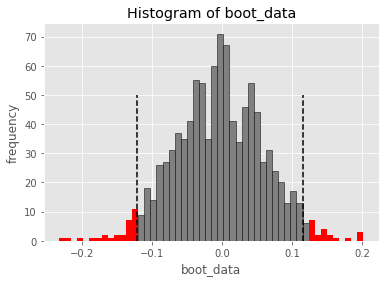

In [23]:
# Применяем бутстрап (с np.median)
booted_data_2 = get_bootstrap(df_control.value, df_test.value, statistic = np.median)

на графике видно, что доверительный интервал теперь пересекает ноль, таким образом мы не можем отклонить нулевую гипотезу

In [24]:
booted_data_2["p_value"]
#можно утверждать, что разница между медианами в контрольной и тестовой группах не наблюдается

0.9584268317031482

In [25]:
booted_data_2["quants"] # ДИ

,0
0.025,-0.120394
0.975,0.115285


Бутстрап по медиане: p_value > 0.05, в доверительный интервал входит 0, значит у нас нет основания отклонять нулевую гипотезу (о равенстве медиан в bootstrap-распределении). По медианам делаем вывод, что значения двух групп статистически не различаются.

In [26]:
mannwhitneyu(df_control.value, df_test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Тест mann-whitney: p_value > 0.05 значит нулевая гипотеза о равенстве распределения выборок - верна. То есть значения двух групп статистически не отличаются

ВЫВОД
T-критерий применить не может, т.к. тестовая группа имеет не нормальное распределение.
Применяя бутстрап с оценкой среднего, мы можем отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия(Скорее всего на это влияют выбросы в тестовой группе).
Однако бутстрап по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05.
U-критерий Манна-Уитни так же не дает отклонить нулевую гипотезу. 
Вывод: изменения НЕ выкатываем